### 해당 모델 관련한 내용

- 차원 축소 : 주어진 피처 공간의 차원 수를 줄이는 기법 -> 차원의 수가 증가할 경우 차원의 저주 현상 발생
- 일반적으로 샘플 수가 피처 수에 대해 지수적으로 증가해야함
- 피처 선택법 vs 피처 추출법
- 피처 선택법 : 전체 피처의 집합에서 일부 부분 집합을 선택하는 방법 => 머신러닝 방법론 이용
- 피처 추출법 : 주어진 데이터의 정보를 최대한 보존하는 새로운 피처 조합을 생성하는 방법  ex)PCA, Isomap, LLE, t-SNE

### PCA 
- 차원 축소를 위한 비지도 학습 모델
- 상관성이 높은 피처를 이용해 새로운 피처를 생성하는 것
- 원 데이터에서 분산이 높은 부분은 최대한 유지하고 분산이 낮은 부분은 들어내는 방향으로 분석


### 해당 모델 파라미터 내용  

- n_components : 추출한 주성분의 수
 - None(default),float,mle
- whiten : 분산 조정 여부
 - False(default) 
- svd_solver : 최적화 알고리즘 선택
 - full, arpack, randomized, auto(default)
- tol : svd_solver가 'arpack'일 때 유지할 특잇값에 대한 허용 요차를 설정
 - 0.0(default)
- iterated_power : svd_solver가 'randomized'일 떄의 이터레이션 횟수
 - auto(default)
- random_state : svd_sover가 'arpack' 이나 'radnomized'일 때 랜덤성을 제어하고자 사용
 - None(default)


### 실제 사용 시 활용 팁
- PCA 클래스는 자동으로 평균 줌심화를 수행하므로 이 과정은 전처리에서 수행하지 않아도 괜찮지만 whitten 하이퍼파라미터의 기본값이 false이므로 분산의 스케일링은 PCA 클래스에서 이루어지지않음
- PCA 클래스 객체는 fit() 메서드를 이용해 n개의 주성분을 학습한다. 학습 후 객체는 transform()메서드를 이용해 테스트 데이터로 학습한 결과 PCA를 수행 가능

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings("ignore")

df = load_digits(as_frame=True)['frame'].sample(frac=0.1, random_state=1234)
X, y = df.drop(['target'], axis=1), df['target']

pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=1234))
mds = make_pipeline(StandardScaler(), MDS(n_components=2, random_state=1234))
isomap = make_pipeline(StandardScaler(), Isomap(n_components=2))
lle = make_pipeline(StandardScaler(), 
                    LocallyLinearEmbedding(n_components=2, random_state=1234))
tsne = make_pipeline(StandardScaler(), TSNE(n_components=2, random_state=1234))

methods = [("PCA", pca), ("MDS", mds), ("Isomap", isomap), ("LLE", lle), 
           ("TSNE", tsne)]

for (name, model) in methods:
    X_transformed = model.fit_transform(X)
    clf = LogisticRegression(random_state=1234).fit(X_transformed, y)
    y_pred = clf.predict(X_transformed)
    
    acc = (y == y_pred).mean() * 100
    print(f'{name} 모델의 정확도: {acc:.2f}%')

PCA 모델의 정확도: 64.44%
MDS 모델의 정확도: 65.56%
Isomap 모델의 정확도: 68.89%
LLE 모델의 정확도: 32.78%
TSNE 모델의 정확도: 82.22%


Best parameter (CV score 0.9237759207675642 ): {'logistic__C': 0.046415888336127774, 'pca__n_components': 60}


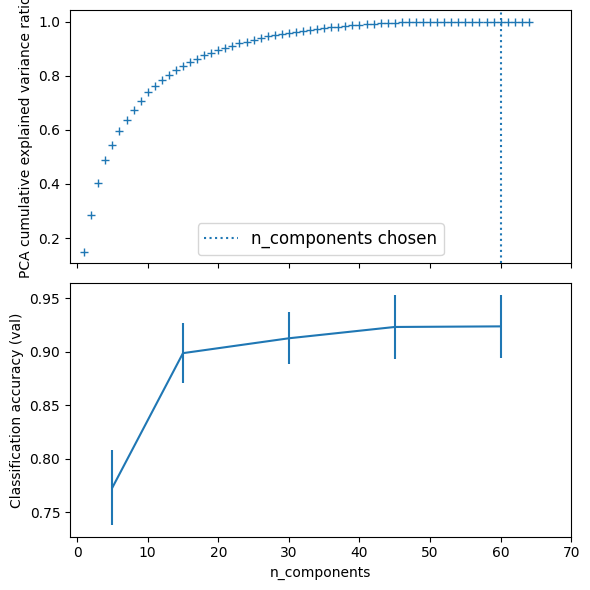

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
%matplotlib inline

X, y = load_digits(return_X_y=True)
scaler = StandardScaler()
pca = PCA(random_state=1234)
logistic = LogisticRegression(max_iter=10000, tol=0.1, random_state=1234)

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 60],
    'logistic__C': np.logspace(-4, 4, 4)
}
search = GridSearchCV(pipe, param_grid)
search.fit(X, y)

print('Best parameter (CV score', search.best_score_, '):',
      search.best_params_)
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         np.cumsum(pca.explained_variance_ratio_),
         "+",
         linewidth=2)
ax0.set_ylabel("PCA cumulative explained variance ratio")

ax0.axvline(search.best_estimator_.named_steps["pca"].n_components,
            linestyle=":",
            label="n_components chosen")
ax0.legend(prop=dict(size=12))

results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score"))

best_clfs.plot(x=components_col,
               y="mean_test_score",
               yerr="std_test_score",
               legend=False,
               ax=ax1)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()